## Image captioning with visual attention

### description

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
!pip uninstall -y tensorflow estimator keras

In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

In [ ]:
!pip install einops

## imports

In [ ]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

## Data handling

### Flickr8k

In [ ]:
# def flickr8k(path='flickr8k'):
#   path = pathlib.Path(path)

#   if len(list(path.rglob('*'))) < 16197:
#     tf.keras.utils.get_file(
#         origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
#         cache_dir='.',
#         cache_subdir=path,
#         extract=True)
#     tf.keras.utils.get_file(
#         origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
#         cache_dir='.',
#         cache_subdir=path,
#         extract=True)
    
#   captions = (path/"Flickr8k.token.txt").read_text().splitlines()
#   captions = (line.split('\t') for line in captions)
#   captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

#   cap_dict = collections.defaultdict(list)
#   for fname, cap in captions:
#     cap_dict[fname].append(cap)

#   train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
#   train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

#   test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
#   test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

#   train_ds = tf.data.experimental.from_list(train_captions)
#   test_ds = tf.data.experimental.from_list(test_captions)

# #   return train_ds, test_ds, train_captions, test_captions
#   return train_ds, test_ds

### Conceptual Captions

In [ ]:
# def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
#   def iter_index(index_path):
#     with open(index_path) as f:
#       for line in f:
#         caption, url = line.strip().split('\t')
#         yield caption, url

#   def download_image_urls(data_dir, urls):
#     ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
#     def save_image(url):
#       hash = hashlib.sha1(url.encode())
#       # Name the files after the hash of the URL.
#       file_path = data_dir/f'{hash.hexdigest()}.jpeg'
#       if file_path.exists():
#         # Only download each file once.
#         return file_path

#       try:
#         result = requests.get(url, timeout=5)
#       except Exception:
#         file_path = None
#       else:
#         file_path.write_bytes(result.content)
#       return file_path
    
#     result = []
#     out_paths = ex.map(save_image, urls)
#     for file_path in tqdm.tqdm(out_paths, total=len(urls)):
#       result.append(file_path)

#     return result

#   def ds_from_index_file(index_path, data_dir, count):
#     data_dir.mkdir(exist_ok=True)
#     index = list(itertools.islice(iter_index(index_path), count))
#     captions = [caption for caption, url in index]
#     urls = [url for caption, url in index]

#     paths = download_image_urls(data_dir, urls)

#     new_captions = []
#     new_paths = []
#     for cap, path in zip(captions, paths):
#       if path is None:
#         # Download failed, so skip this pair.
#         continue
#       new_captions.append(cap)
#       new_paths.append(path)
    
#     new_paths = [str(p) for p in new_paths]

#     ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
#     ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
#     return ds

#   data_dir = pathlib.Path(data_dir)
#   train_index_path = tf.keras.utils.get_file(
#     origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
#     cache_subdir=data_dir,
#     cache_dir='.')
  
#   val_index_path = tf.keras.utils.get_file(
#     origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
#     cache_subdir=data_dir,
#     cache_dir='.')
  
#   train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
#   test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

#   return train_raw, test_raw

### coco bangla

#### copy from drive

In [ ]:
!mkdir -p "/content/data/coco"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!rsync -ah --progress "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/coco-dataset-2017/annotations" "/content/data/coco"
# !rsync -ah --progress "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/coco-dataset-2017/train2017.zip" "/content/data/coco"
# !rsync -ah --progress "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/coco-dataset-2017/val2017.zip" "/content/data/coco"

#### extract

In [ ]:
# !unzip "/content/data/coco/train2017.zip" -d "/content/data/coco"
# !unzip "/content/data/coco/val2017.zip" -d "/content/data/coco"
!unzip "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/coco-dataset-2017/train2017.zip" -d "/content/data/coco"
!unzip "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/coco-dataset-2017/val2017.zip" -d "/content/data/coco"

In [ ]:
drive.flush_and_unmount()

#### load coco bangla

In [ ]:
import json
import os
import pickle

In [ ]:
%cd /content/

In [ ]:
data_dir = '/content/data/coco'

In [ ]:
def _load_bangla_coco(train=True, count=100):
    if train:
        # Training-set.
        filename = "captions_train2017_refined_translated.json"
    else:
        # Validation-set.
        filename = "captions_val2017_refined_translated.json"
    
    filepath = os.path.join(data_dir, "annotations", filename)

    with open(filepath, "r", encoding="utf-8") as input_file:
        data_raw = json.load(input_file)

    if not train:
        count = count//5
    if count <= len(data_raw):
        new_data_raw=dict()
        for i, data_key in enumerate(data_raw):
            if i < count:
                new_data_raw[data_raw[data_key]['id']] = data_raw[data_key]
            else:
                break
        data_raw = new_data_raw

    file_root=f"{data_dir}"
    if train:
        file_root=f"{file_root}/train2017"
    else:
        file_root=f"{file_root}/val2017"
    
    records_list = [(f"{file_root}/{record['file_name']}", record['captions'][:5])
                        for key, record in data_raw.items()]

    # filenames, captions = zip(*records_list)
    # return filenames, captions
    return records_list

In [ ]:
def load_bangla_coco(train=True, count=100):
    if train:
        # Cache-file for the training-set data.
        cache_filename = "records_train.pkl"
    else:
        # Cache-file for the validation-set data.
        cache_filename = "records_val.pkl"

    # Path for the cache-file.
    cache_path = os.path.join(data_dir, cache_filename)

    # If the data-records already exist in a cache-file then load it,
    # otherwise call the _load_records() function and save its
    # return-values to the cache-file so it can be loaded the next time.

    if os.path.exists(cache_path):
        # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            obj = pickle.load(file)

        print("- Data loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.

        # Call the function / class-init with the supplied arguments.
        obj = _load_bangla_coco(train=train, count=count)

        # Save the data to a cache-file.
        with open(cache_path, mode='wb') as file:
            pickle.dump(obj, file)

        print("- Data saved to cache-file: " + cache_path)

    return obj

##### check

In [ ]:
val_obj = load_bangla_coco(train=False)

In [ ]:
type(val_obj[0])

In [ ]:
len(val_obj)

In [ ]:
val_obj[0]

('/content/data/coco/val2017/000000397133.jpg',
 ['একজন লোক রান্নাঘরে পিজ্জা তৈরি করছে।',
  'প্যান এবং বেকওয়্যার নিয়ে চুলার সামনে দাঁড়িয়ে এপ্রোন পরা মানুষ',
  'একজন বেকার রান্নাঘরে ময়দা তৈরির কাজ করছে।',
  'রান্নাঘরে চুলার পাশে দাঁড়িয়ে থাকা একজন ব্যক্তি।',
  'পাইসহ একটি টেবিল তৈরি করা হচ্ছে এবং একজন ব্যক্তি দেয়ালের কাছে হাঁড়ি ও প্যান ঝুলছে।'])

In [ ]:
# train_raw = tf.data.experimental.from_list(train_obj)
test_raw = tf.data.experimental.from_list(val_obj)

In [ ]:
test_raw

<_ListDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))>

In [ ]:
test_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
# for ex_path, ex_captions in test_raw.take(1):
#   print(ex_path)
#   print(ex_captions)

tf.Tensor(b'data/coco/val_2017/000000397133.jpg', shape=(), dtype=string)
tf.Tensor(
[b'\xe0\xa6\x8f\xe0\xa6\x95\xe0\xa6\x9c\xe0\xa6\xa8 \xe0\xa6\xb2\xe0\xa7\x8b\xe0\xa6\x95 \xe0\xa6\xb0\xe0\xa6\xbe\xe0\xa6\xa8\xe0\xa7\x8d\xe0\xa6\xa8\xe0\xa6\xbe\xe0\xa6\x98\xe0\xa6\xb0\xe0\xa7\x87 \xe0\xa6\xaa\xe0\xa6\xbf\xe0\xa6\x9c\xe0\xa7\x8d\xe0\xa6\x9c\xe0\xa6\xbe \xe0\xa6\xa4\xe0\xa7\x88\xe0\xa6\xb0\xe0\xa6\xbf \xe0\xa6\x95\xe0\xa6\xb0\xe0\xa6\x9b\xe0\xa7\x87\xe0\xa5\xa4'
 b'\xe0\xa6\xaa\xe0\xa7\x8d\xe0\xa6\xaf\xe0\xa6\xbe\xe0\xa6\xa8 \xe0\xa6\x8f\xe0\xa6\xac\xe0\xa6\x82 \xe0\xa6\xac\xe0\xa7\x87\xe0\xa6\x95\xe0\xa6\x93\xe0\xa6\xaf\xe0\xa6\xbc\xe0\xa7\x8d\xe0\xa6\xaf\xe0\xa6\xbe\xe0\xa6\xb0 \xe0\xa6\xa8\xe0\xa6\xbf\xe0\xa6\xaf\xe0\xa6\xbc\xe0\xa7\x87 \xe0\xa6\x9a\xe0\xa7\x81\xe0\xa6\xb2\xe0\xa6\xbe\xe0\xa6\xb0 \xe0\xa6\xb8\xe0\xa6\xbe\xe0\xa6\xae\xe0\xa6\xa8\xe0\xa7\x87 \xe0\xa6\xa6\xe0\xa6\xbe\xe0\xa6\x81\xe0\xa6\xa1\xe0\xa6\xbc\xe0\xa6\xbf\xe0\xa6\xaf\xe0\xa6\xbc\xe0\xa7\x87 \xe0\xa6\x8f\xe0\xa

### reading data

dataset return type:

- list of tuples
- each tuple is a filename and list of captions

In [ ]:
# choose = 'flickr8k'
choose = 'coco'

print(f'choice is {choose}')

if choose == 'flickr8k':
    #   train_raw, test_raw, train_captions, test_captions = flickr8k()
    train_raw, test_raw = flickr8k()
elif choose == 'coco':
    train_obj = load_bangla_coco(train=True, count=32000)
    val_obj = load_bangla_coco(train=False, count=5000)
    train_raw = tf.data.experimental.from_list(train_obj)
    test_raw = tf.data.experimental.from_list(val_obj)
else:
    train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)


choice is coco
- Data saved to cache-file: /content/data/coco/records_train.pkl
- Data saved to cache-file: /content/data/coco/records_val.pkl


The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k and COCO dataset contain 5 captions per image, while Conceptual Captions has 1:

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
test_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions.shape)

tf.Tensor(b'/content/data/coco/train2017/000000391895.jpg', shape=(), dtype=string)
(5,)


## Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [ ]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

Here's a function to load an image and resize it for the model:

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


## Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# Use the top 5000 words for a vocabulary.
# vocabulary_size = 5000
vocabulary_size = 29000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
len(tokenizer.get_vocabulary())

24329

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'একটি', '[START]', '[END]', 'একজন', 'এবং', 'সহ', 'বসে', 'আছে।']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 7522, 1, 1, 7522, 24027, 4], [3, 7522, 1, 1, 4]]>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'[UNK]', b'[UNK]', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'[UNK]', b'[UNK]', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a [UNK] [UNK] a hat [END]',
       b'[START] a [UNK] [UNK] [END]'], dtype=object)

## Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
# for ex_paths, ex_captions in train_raw.batch(64).take(1):
#   break

# print('image paths:', ex_paths.shape)
# print('captions:', ex_captions.shape)
# print()

# ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

# print('image_paths:', ex_paths.shape)
# print('captions:', ex_captions.shape)


image paths: (64,)
captions: (64, 5)

image_paths: (320,)
captions: (320,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=64, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [ ]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=64):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=64, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

500it [04:28,  1.86it/s]
16it [00:09,  1.73it/s]


 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(64, 7, 7, 576)
(64, 15)
(64, 15)


The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    5  746   68   32   83    2  154 3241    0    0    0    0    0
    0]
[   5  746   68   32   83    2  154 3241    4    0    0    0    0    0
    0]


## A Transformer decoder model

### description

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))

In [ ]:
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 2500/2500 [01:18<00:00, 31.86it/s]


Uniform entropy: 10.10
Marginal entropy: 6.24


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

#### test image download

for output at each epoch

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

#### caption generate

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=0.5):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

#### checking caption at the beginning

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি একটি

এবং অর্ধেক সহ নিচে একটি পরা রয়েছে। chay একটি তুষার মালভূমিতে ব্যান্ডের মাংসে জিরাফ একটি একজন একসাথে আকাশ এবং কিশোরী একা একসাথে এবং বাটি।


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    # print()
    # print()
    # for t in (0.0, 0.5, 1.0):
    #   result = self.model.simple_gen(self.image, temperature=t)
    #   print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [ ]:
## first run 50 epochs
## second run 12 epochs
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    # steps_per_epoch=10,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    # validation_steps=10,
    # epochs=100,
    epochs=50,
    callbacks=callbacks)

Epoch 1/50
  6/100 [>.............................] - ETA: 21s - loss: 3.4116 - masked_acc: 0.3800

100/100 [==============================] - 19s 183ms/step - loss: 3.4289 - masked_acc: 0.3761 - val_loss: 3.4327 - val_masked_acc: 0.3803
Epoch 2/50
100/100 [==============================] - 16s 155ms/step - loss: 3.4129 - masked_acc: 0.3802 - val_loss: 3.4826 - val_masked_acc: 0.3733
Epoch 3/50
100/100 [==============================] - 17s 171ms/step - loss: 3.3748 - masked_acc: 0.3813 - val_loss: 3.4035 - val_masked_acc: 0.3758
Epoch 4/50
100/100 [==============================] - 16s 155ms/step - loss: 3.3862 - masked_acc: 0.3796 - val_loss: 3.4920 - val_masked_acc: 0.3759
Epoch 5/50
100/100 [==============================] - 20s 199ms/step - loss: 3.3996 - masked_acc: 0.3803 - val_loss: 3.4314 - val_masked_acc: 0.3739
Epoch 6/50
100/100 [==============================] - 19s 192ms/step - loss: 3.3961 - masked_acc: 0.3783 - val_loss: 3.3902 - val_masked_acc: 0.3781
Epoch 7/50
100/100 [==============================] - 17s 174ms/step - loss: 3.3739 - masked_acc: 0.3808 - val_loss: 

#### save model

In [ ]:
model_wt_path = "/content/bn_caption_model_weights"

In [ ]:
model.save_weights(f'{model_wt_path}')

##### save in drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!rsync -ah --progress "/content/bn_caption_model_weights.data-00000-of-00001" "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/models"
!rsync -ah --progress "/content/bn_caption_model_weights.index" "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/models/"

load

In [ ]:
!rsync -ah --progress "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/models/bn_caption_model_weights.data-00000-of-00001" "/content/"
!rsync -ah --progress "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/models/bn_caption_model_weights.index" "/content/"

In [ ]:
drive.flush_and_unmount()

#### load model

In [ ]:
# model_check = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
#                   units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
# model_check.load_weights(f'{model_wt_path}')
model.load_weights(f'{model_wt_path}')

### plot

Plot the loss and accuracy over the training run:

In [ ]:
!mkdir -p "/content/figures"

In [ ]:
old_loss = history.history['loss'].copy()
old_val_loss = history.history['val_loss'].copy()

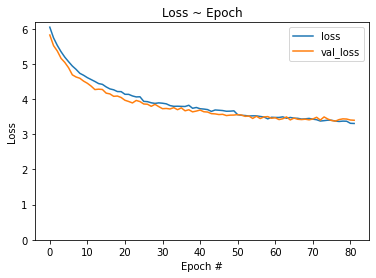

In [ ]:
plt.plot(old_loss + history.history['loss'], label='loss')
plt.plot(old_val_loss + history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss ~ Epoch')
plt.savefig(f'/content/figures/loss.pdf')

In [ ]:
old_acc = history.history['masked_acc'].copy()
old_val_acc = history.history['val_masked_acc'].copy()

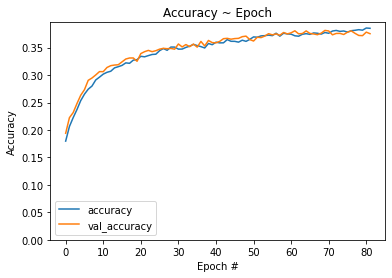

In [ ]:
plt.plot(old_acc + history.history['masked_acc'], label='accuracy')
plt.plot(old_val_acc + history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy ~ Epoch')
plt.savefig(f'/content/figures/accuracy.pdf')

## testing results

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
def get_caption(image_path=None, image_url=None, image_show=True, temperature=0.5):
    if image_path is None:
        image_file_name = image_url.split('/')[-1]
        image_path = tf.keras.utils.get_file(f'{image_file_name}', origin=image_url)

    image = load_image(image_path)

    result = model.simple_gen(image, temperature=temperature)

    if image_show:
        img = mpimg.imread(f'{image_path}')
        imgplot = plt.imshow(img)
        plt.show()
    return image, result

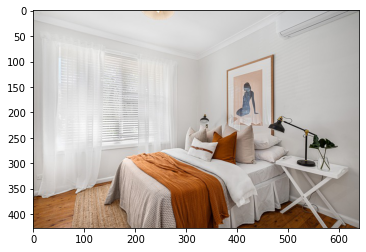

লাল দেয়াল সহ একটি সাদা বিছানা এবং একটি ঘর


In [ ]:
image, result = get_caption(image_url='https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg', temperature=0.5)

print(result)

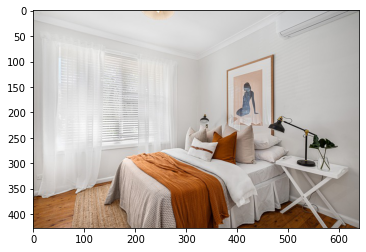

একটি বিছানা এবং একটি বাতি সহ একটি বিছানা ঘর


In [ ]:
image, result = get_caption(image_url='https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg', temperature=0.5)

print(result)

## Attention plots

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 10, 49]), TensorShape([1, 2, 10, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999999 ],
      dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

bangla font in plot

In [ ]:
!wget https://www.omicronlab.com/download/fonts/kalpurush.ttf

--2023-02-28 21:03:59--  https://www.omicronlab.com/download/fonts/kalpurush.ttf
Resolving www.omicronlab.com (www.omicronlab.com)... 172.104.46.32
Connecting to www.omicronlab.com (www.omicronlab.com)|172.104.46.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314592 (307K) [application/octet-stream]
Saving to: ‘kalpurush.ttf’

kalpurush.ttf       100%[===================>] 307.22K   562KB/s    in 0.5s    

2023-02-28 21:04:01 (562 KB/s) - ‘kalpurush.ttf’ saved [314592/314592]



In [ ]:
prop = fm.FontProperties(fname='kalpurush.ttf')

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i], fontproperties=prop))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

Now put that together into a more usable function:

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0, save_figure=False, save_path=None):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt, fontproperties=prop)
  t.set_y(1.05)

  if save_figure and save_path is not None:
      plt.savefig(f'{save_path}')
      print(f"figure saved at {save_path}")


### Try it on your own images

figure saved at /content/figures/bedroom_hrnet_tutorial.jpg.pdf


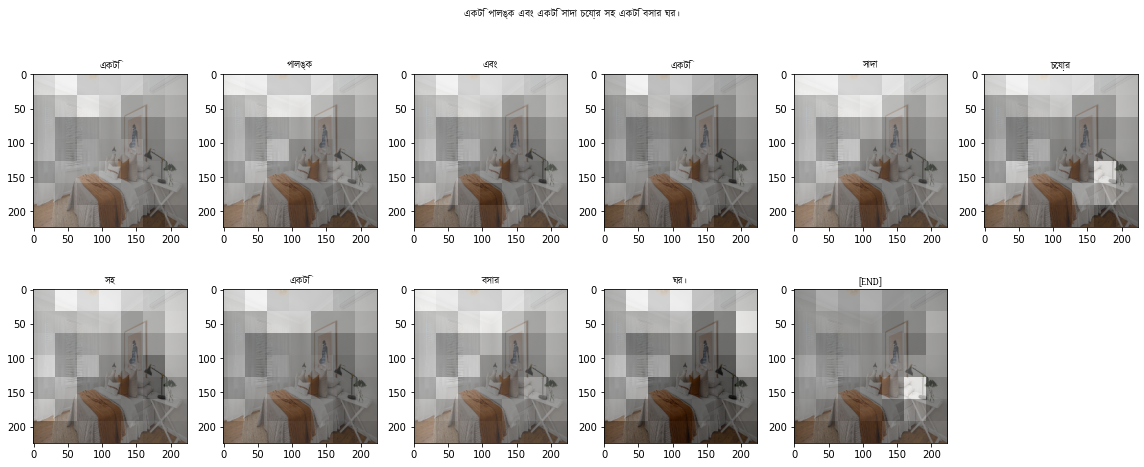

In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image, result = get_caption(image_url=image_url,image_show=False)
# print(result)
run_and_show_attention(model, image,temperature=0.5, save_figure=True, save_path=f"/content/figures/{image_url.split('/')[-1]}.pdf")

61272/61272 [==============================] - 0s 0us/step
figure saved at /content/figures/521px-Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg.pdf


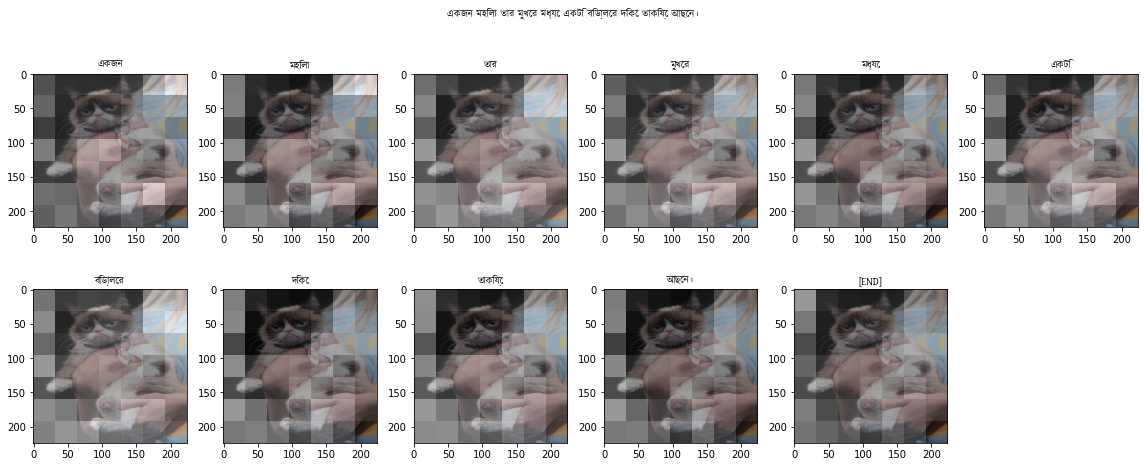

In [ ]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg/521px-Grumpy_Cat_%2814556024763%29_%28cropped%29.jpg'
image, result = get_caption(image_url=image_url,image_show=False)
# print(result)
run_and_show_attention(model, image,temperature=0.5, save_figure=True, save_path=f"/content/figures/{image_url.split('/')[-1]}.pdf")

figure saved at /content/figures/19-Beautiful-Smile-Quotes-For-Your-Children-1-911x1024.jpg.pdf


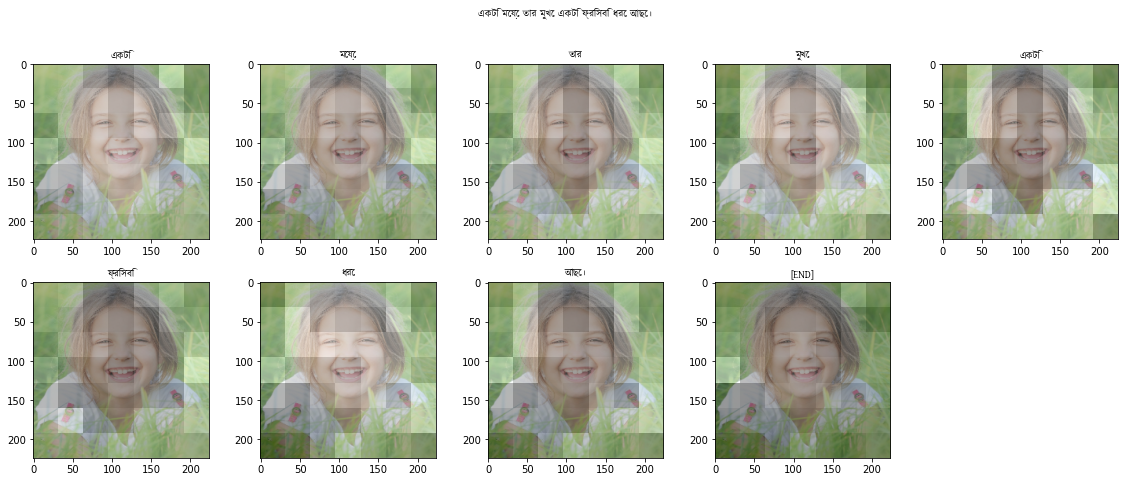

In [ ]:
image_url = 'https://cdn2.momjunction.com/wp-content/uploads/2016/02/19-Beautiful-Smile-Quotes-For-Your-Children-1-911x1024.jpg'
image, result = get_caption(image_url=image_url,image_show=False)
# print(result)
run_and_show_attention(model, image,temperature=0.5, save_figure=True, save_path=f"/content/figures/{image_url.split('/')[-1]}.pdf")

figure saved at /content/figures/image.png.pdf


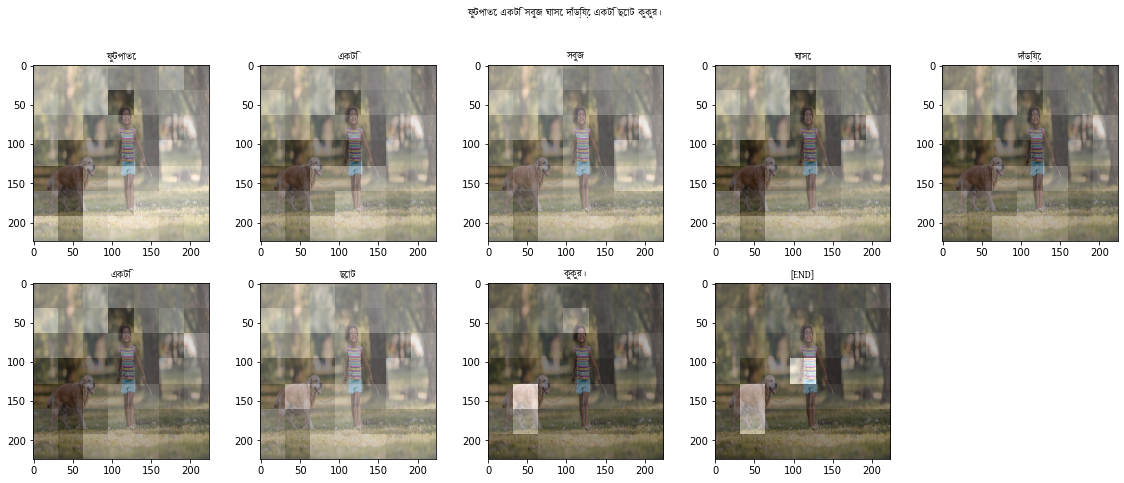

In [ ]:
image_url = 'https://i.ibb.co/xznFpYY/image.png'
image, result = get_caption(image_url=image_url,image_show=False)
# print(result)
run_and_show_attention(model, image,temperature=1.0, save_figure=True, save_path=f"/content/figures/{image_url.split('/')[-1]}.pdf")

## banglalekha testing

### download images

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/rxxch9vw59/files/220ffc5a-8645-4c0b-bd1b-97188836ed3b/file_downloaded

In [ ]:
!mv file_downloaded /content/banglalekha_images.zip

### copy from drive

In [ ]:
# from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !rsync -ah --progress "/content/test_cache" "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/models/"
# !rsync -ah --progress "/content/train_cache" "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/models/"

### extract

In [ ]:
!7z x "/content/drive/MyDrive/My Drive (1705092)/Study Materials/Level 4 - Term 2/CSE471-472/CSE472/ML project/data/banglalekha_images.zip"

In [ ]:
drive.flush_and_unmount()

In [ ]:
!mkdir -p /content/data/banglalekha

In [ ]:
!mv images /content/data/banglalekha

### test on banglalekha

In [ ]:
banglalekha_images_root = "/content/data/banglalekha/images"

In [ ]:
# banglalekha_images = sorted(os.listdir(banglalekha_images_root))
banglalekha_images = os.listdir(banglalekha_images_root)

In [ ]:
# banglalekha_images_path = [f'{banglalekha_images_root}/{x}' for x in banglalekha_images]

In [ ]:
check_images = banglalekha_images[:1000]

In [ ]:
banglalekha_results=dict()

In [ ]:
for x in tqdm.tqdm(check_images):
    image, result = get_caption(image_path=f"{banglalekha_images_root}/{x}",image_show=False)
    # print(result)
    banglalekha_results[x]=[result]

In [ ]:
def view_results(image_names, results_dict=banglalekha_results, image_root=banglalekha_images_root):
    for x in image_names:
        img = mpimg.imread(f'{image_root}/{x}')
        imgplot = plt.imshow(img)
        plt.show()
        print(results_dict[x])

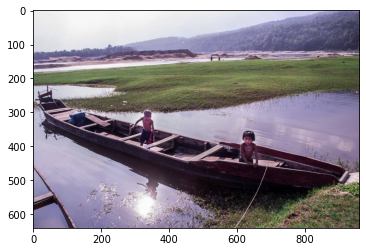

['একটি নৌকায় বেশ কিছু লোক বসে আছে']


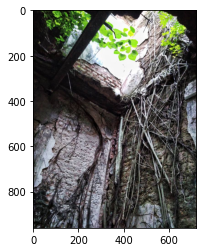

['একটি গাছের পাশে একটি গাছের ডালে বসে আছে।']


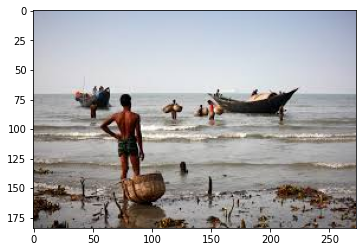

['সার্ফবোর্ড সহ সমুদ্র সৈকতে মানুষ তাদের সার্ফবোর্ডে চড়ছেন।']


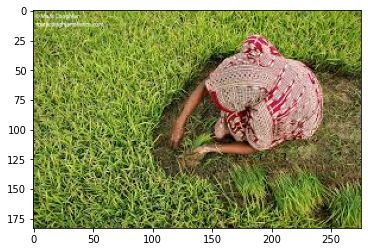

['একটি ফ্রিসবি সঙ্গে একটি মাঠে একটি ছোট শিশু।']


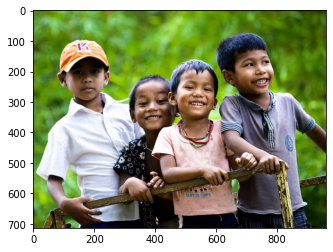

['একটি যুবতী টেনিস র\u200c্যাকেট ধরে আছে।']


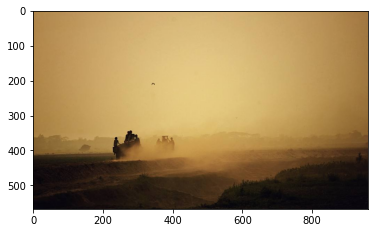

['একটি কুকুর একটি সমুদ্র সৈকতে একটি সার্ফবোর্ড ধরে রেখেছে।']


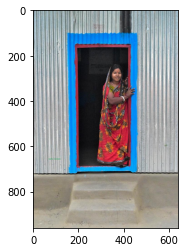

['একটি ইটের দেয়ালের সামনে একটি পুরানো লাগেজ এবং একটি ছোট ছেলে']


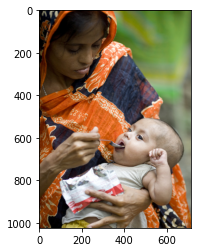

['একটি টেডি বিয়ার একটি টেডি বিয়ার ধরে আছে।']


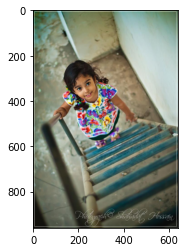

['একটি ছেলে একটি স্কেটবোর্ডে একটি কৌশল করছে।']


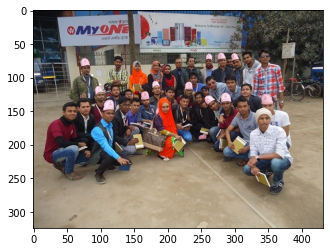

['একগুচ্ছ লোক তাদের লাগেজ নিয়ে দাঁড়িয়ে আছে।']


In [ ]:
view_results(check_images[-10:])

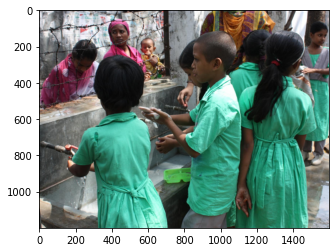

['একদল লোক যারা কিছু খাবার খাচ্ছে।']


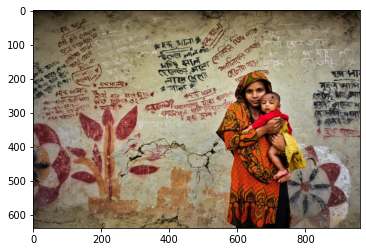

['একটি শিশু তার পিঠে একটি হাতির চারপাশে দাঁড়িয়ে আছে।']


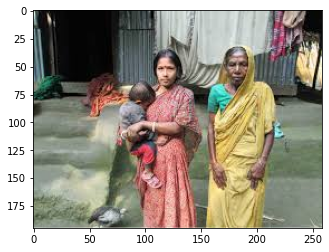

['একটি মেয়ে একটি কুকুরের সাথে একটি বড় স্টাফ জন্তু ধরে আছে']


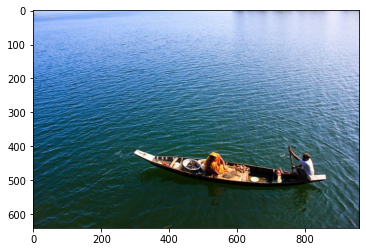

['একটি ছোট নৌকায় দাঁড়িয়ে থাকা এক ব্যক্তি।']


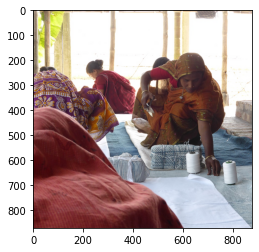

['একজন মহিলা ছাতার নিচে বসে আছেন এবং লোকেরা তাদের পিছনে দাঁড়িয়ে দেখছেন।']


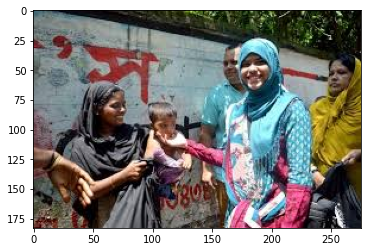

['একজন লোক একটি বিল্ডিংয়ের সামনে দাঁড়িয়ে আছে']


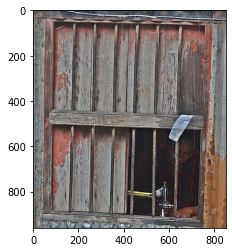

['একটি পুরানো ভবনের সামনে একটি কাঠের বেঞ্চে বসা একটি কাঠের বেঞ্চ।']


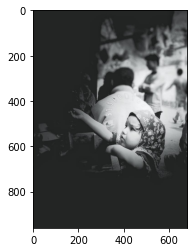

['একটি টেডি বিয়ার একটি কালো এবং সাদা ছবি']


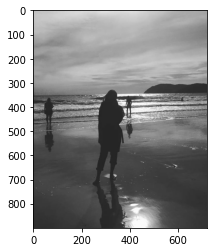

['একজন ব্যক্তি জলের কাছে একটি সার্ফবোর্ড ধরে আছেন।']


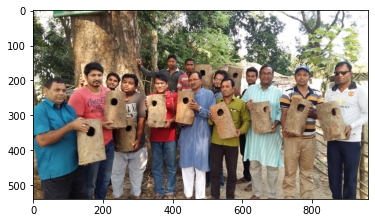

['দাঁড়িয়ে থাকা একদল লোক তাদের সেল ফোনে কথা বলছে।']


In [ ]:
view_results(check_images[0:10])

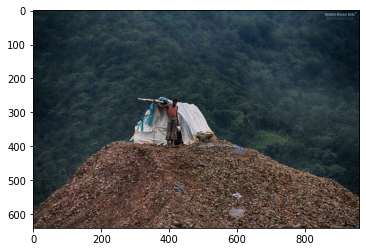

['একটি বড় পাথরের উপর একটি সাদা ঘোড়া']


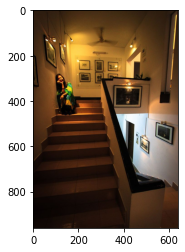

['একটি ছোট ঘরে একটি সাদা সিঙ্ক এবং একটি বড় জানালা']


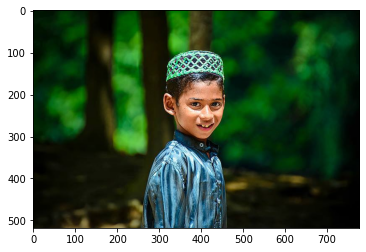

['একটি স্যুট পরা একজন লোক তার পিছনে দাঁড়িয়ে আছে']


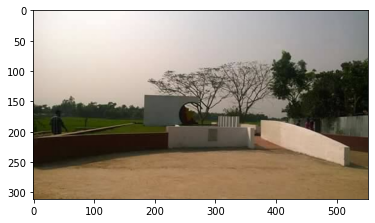

['একটি বিছানা এবং একটি চেয়ার সহ একটি খালি ঘর।']


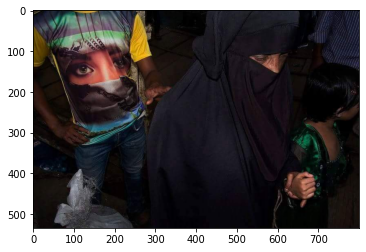

['একজন লোক তার সেল ফোনে কথা বলার সময় একটি টাই পরা।']


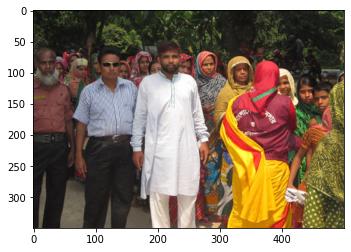

['একটি মাঠে দাঁড়িয়ে থাকা দুই ব্যক্তি একটি ছবির জন্য পোজ দিচ্ছেন।']


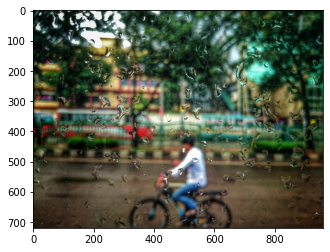

['একজন ব্যক্তি একটি টেনিস বল আঘাত করার জন্য প্রস্তুত হচ্ছে।']


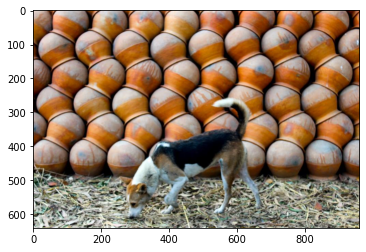

['একটি পাখি জলের মধ্যে একটি ছোট পাখির দিকে তাকিয়ে আছে।']


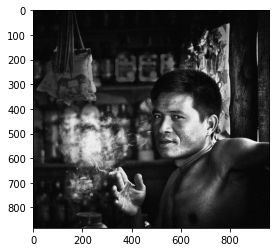

['একটি কালো এবং সাদা বিড়াল একটি ছবির জন্য পোজ দিচ্ছে।']


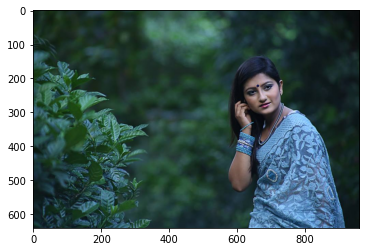

['একটি মেয়ে একটি গাছের নিচে বসে আছে।']


In [ ]:
view_results(check_images[100:110])

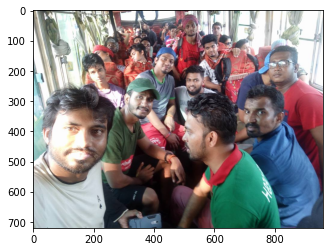

['একটি তরুণ পুরুষ এবং মহিলা একটি ছবির জন্য পোজ দিচ্ছেন।']


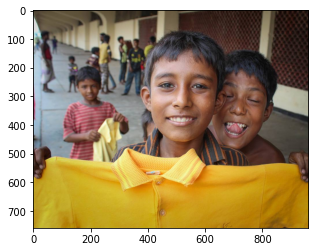

['একটি কাঠের টেবিলে বসে থাকা একজন মানুষ।']


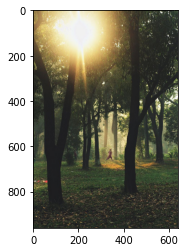

['একটি কালো এবং সাদা ফুল সহ একটি পাথরের দেয়ালের পাশে দাঁড়িয়ে আছে']


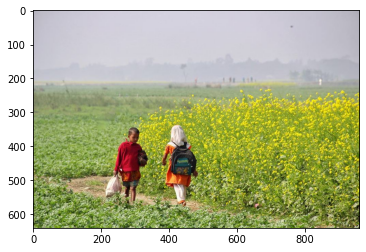

['একজন ব্যক্তি একটি মাঠে ফ্রিসবি নিয়ে খেলা খেলছেন।']


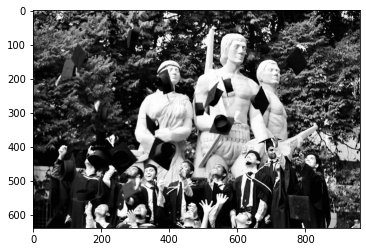

['একটি পুরানো কালো এবং সাদা ছবি।']


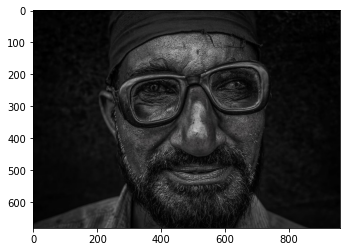

['চশমা পরা একজন লোক একটি টাই এবং একটি টুপি পরে আছে।']


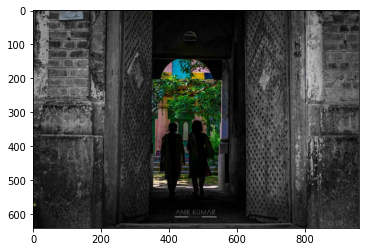

['একটি বড় ভবন।']


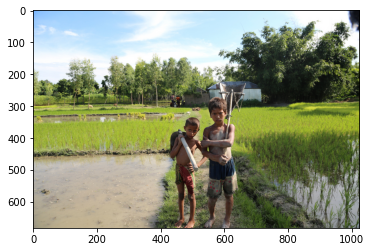

['একজন লোক তার পিঠে বসে আছে']


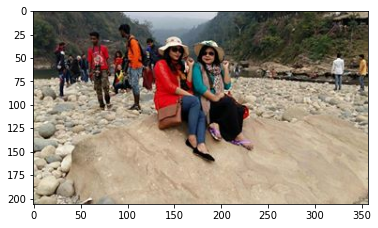

['লোকেরা একটি সৈকতে হাঁটছে এবং একটি সার্ফ বোর্ড ধরে রেখেছে।']


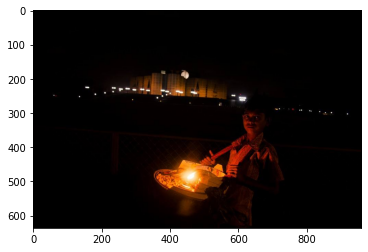

['একজন ব্যক্তি রাতে একটি রাতে রাতে একটি রাস্তায় হাঁটছেন।']


In [ ]:
view_results(check_images[500:510])

### banglalekha labels

#### download

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/rxxch9vw59/files/9b3e789a-5a5c-48b3-8a2c-2c91e9307c2a/file_downloaded -O "banglalekha_captions.json"

In [ ]:
!mv "banglalekha_captions.json" "/content/data/banglalekha/"

#### read labels

In [ ]:
with open("/content/data/banglalekha/banglalekha_captions.json", "r", encoding="utf-8") as label_file:
    label_raw = json.load(label_file)

In [ ]:
label_raw[0]

{'filename': '1.png',
 'caption': ['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।',
  'একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। ']}

#### extract

In [ ]:
banglalekha_labels=banglalekha_results.copy()

In [ ]:
for sample in label_raw:
    if sample['filename'] in banglalekha_labels.keys():
        banglalekha_labels[sample['filename']] = sample['caption']

In [ ]:
banglalekha_labels

{'545.png': ['কয়েকজন শিশু হাত ধৌত করছে।',
  'কিছু বাচ্চা হাত ধুচ্ছে আর তাদের সামনে ৩ জন মহিলা যাদের একজনের কোলে একটি বাচ্চা।'],
 '470.png': ['একজন নারী একটি শিশু কোলে নিয়ে দাড়িয়ে আছে।',
  'একজন মহিলা একটি শিশু কোলে করে দারিয়ে আছে।'],
 '2149.png': ['ছয়জন মেয়ে যেমন খুশি তেমন সাজো অনুষ্ঠানে সামনে দাঁড়ানো তিনজন কমলা শাড়ি, হাতে একতারা নিয়ে বৈস্টমি ও পেছনের তিনজন বৈরাগী সেজেছে।',
  'ছয়জন মেয়ে শিশু হলুদ শাড়ি পরে আছে।'],
 '8785.png': ['একটা নৌকায় একজন মহিলা বসে আছে আর মাঝি নৌকা বাইচে।',
  'নৌকায় একজন পুরুষ ও একজন নারী বসে আছে।'],
 '3392.png': ['কয়েকজন নারী আছে।',
  'কয়েকজন মহিলা কাঁথা সেলায় করছে বসে এবং একজন মহিলা সামনে সূতা ধরে আছে। '],
 '861.png': ['নারী ও শিশু আছে।', 'কয়েকজন মানুষ।'],
 '8733.png': ['জানালা দিয়ে দেখা যাচ্ছে একজন মহিলা সেলাই মেশিনে বসে সেলাই করছে।',
  'জানালা দিয়ে একজন মানুষ দেখা যাচ্ছে।'],
 '3483.png': ['একটি শিশু হাত তুলে আছে। পিছনে কয়েকজন মানুষ আছে।',
  '১ জন বাচ্চা মেয়ে হাত বাড়িয়ে দোকানে কিছু দিচ্ছে। '],
 '1024.png': ['সমুদ্রের পাশে তিনজন মানুষ আছে।', 'সমুদ্র তীরে ৩ জন মা

In [ ]:
banglalekha_results

{'545.png': ['একদল লোক যারা কিছু খাবার খাচ্ছে।'],
 '470.png': ['একটি শিশু তার পিঠে একটি হাতির চারপাশে দাঁড়িয়ে আছে।'],
 '2149.png': ['একটি মেয়ে একটি কুকুরের সাথে একটি বড় স্টাফ জন্তু ধরে আছে'],
 '8785.png': ['একটি ছোট নৌকায় দাঁড়িয়ে থাকা এক ব্যক্তি।'],
 '3392.png': ['একজন মহিলা ছাতার নিচে বসে আছেন এবং লোকেরা তাদের পিছনে দাঁড়িয়ে দেখছেন।'],
 '861.png': ['একজন লোক একটি বিল্ডিংয়ের সামনে দাঁড়িয়ে আছে'],
 '8733.png': ['একটি পুরানো ভবনের সামনে একটি কাঠের বেঞ্চে বসা একটি কাঠের বেঞ্চ।'],
 '3483.png': ['একটি টেডি বিয়ার একটি কালো এবং সাদা ছবি'],
 '1024.png': ['একজন ব্যক্তি জলের কাছে একটি সার্ফবোর্ড ধরে আছেন।'],
 '2398.png': ['দাঁড়িয়ে থাকা একদল লোক তাদের সেল ফোনে কথা বলছে।'],
 '1974.png': ['একটি মেয়ে একটি গোলাপী শার্ট এবং টাই পরা একজন ব্যক্তি'],
 '5524.png': ['একজন ব্যক্তি একটি বস্তু ধরে আছেন যখন সে তার হাত ধরে রেখেছে।'],
 '1944.png': ['একটি রেস্তোরাঁর টেবিলে বসে থাকা এক গ্লাস ওয়াইন গ্লাস ওয়াইন গ্লাস ওয়াইন গ্লাস থেকে পান'],
 '8302.png': ['একটি বড় ভবনের সামনে একটি বড় ক্লক টাওয়ার']

## CIDEr

In [ ]:
import copy
import numpy as np
import pdb
import math

def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    # counts = dict(int)
    counts = dict()
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = " ".join(words[i:i+k])
            # ngram = tuple(words[i:i+k])
            if ngram in counts.keys():
                counts[ngram] += 1
            else:
                counts[ngram] = 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        # self.document_frequency = dict(float)
        self.document_frequency = dict()
        self.cook_append(test, refs)
        self.ref_len = None

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                if ngram in self.document_frequency.keys():
                    self.document_frequency[ngram] += 1
                else:
                    self.document_frequency[ngram] = 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [dict() for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                if ngram in self.document_frequency:
                    df = np.log(max(1.0, self.document_frequency[ngram]))
                else:
                    df = np.log(1.0)
                # ngram index
                n = len(ngram.split())-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    # vrama91 : added clipping
                    if ngram in vec_ref[n].keys() and ngram in vec_hyp[n].keys():
                        val[n] += min(vec_hyp[n][ngram], vec_ref[n][ngram]) * vec_ref[n][ngram]
                    else:
                        val[n] += 0

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
                # vrama91: added a length based gaussian penalty
                val[n] *= np.e**(-(delta**2)/(2*self.sigma**2))
            return val

        # compute log reference length
        self.ref_len = np.log(float(len(self.crefs)))

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, option=None, verbose=0):
        # compute idf
        self.compute_doc_freq()
        # assert to check document frequency
        assert(len(self.ctest) >= max(self.document_frequency.values()))
        # compute cider score
        score = self.compute_cider()
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)

In [ ]:
class Cider:
    """
    Main Class to compute the CIDEr metric 

    """
    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        # set cider to sum over 1 to 4-grams
        self._n = n
        # set the standard deviation parameter for gaussian penalty
        self._sigma = sigma

    def compute_score(self, gts, res):
        """
        Main function to compute CIDEr score
        :param  hypo_for_image (dict) : dictionary with key <image> and value <tokenized hypothesis / candidate sentence>
                ref_for_image (dict)  : dictionary with key <image> and value <tokenized reference sentence>
        :return: cider (float) : computed CIDEr score for the corpus 
        """

        assert(gts.keys() == res.keys())
        imgIds = gts.keys()

        cider_scorer = CiderScorer(n=self._n, sigma=self._sigma)

        for id in imgIds:
            hypo = res[id]
            ref = gts[id]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)

            cider_scorer += (hypo[0], ref)

        (score, scores) = cider_scorer.compute_score()

        return score, scores

    def method(self):
        return "CIDEr"

In [ ]:
# hypo = banglalekha_results.copy()
# ref = banglalekha_labels.copy()

In [ ]:
# for key, val in hypo.items():
#     hypo[key] = tokenizer(val).to_tensor().numpy().tolist()

In [ ]:
# for key, val in ref.items():
#     ref[key] = tokenizer(val).to_tensor().numpy().tolist()

In [ ]:
grams=4
sigma=100.0

In [ ]:
cd = Cider(n=grams, sigma=sigma)

In [ ]:
avg_score, scores = cd.compute_score(gts=banglalekha_labels, res=banglalekha_results)

In [ ]:
avg_score

0.05042473719794286